## Official Cohort Default Rates for Schools from the U.S. Department of Education
Exploratory analysis<br>
Elizabeth Clark<br>
Feb. 5, 2018

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
%matplotlib inline

Data was downloaded from https://www2.ed.gov/offices/OSFAP/defaultmanagement/cdr.html: FY 2014, FY 2013, and FY 2012 official cohort default rates published for schools participating in the Title IV student financial assistance programs.

In [4]:
# Load data
xlsx = pd.ExcelFile('peps300.xlsx')
title5_default = pd.read_excel(xlsx)

# Check for duplicate records
x1 = title5_default.drop_duplicates('OPEID')
x2 = x1.drop_duplicates(['Name', 'City', 'State', 'Address'])
if len(title5_default) == len(x1) == len(x2):
    print('there are no duplicates.')

there are no duplicates.


### Fig. 1: Cohort-to-cohort correlation between loan default rates

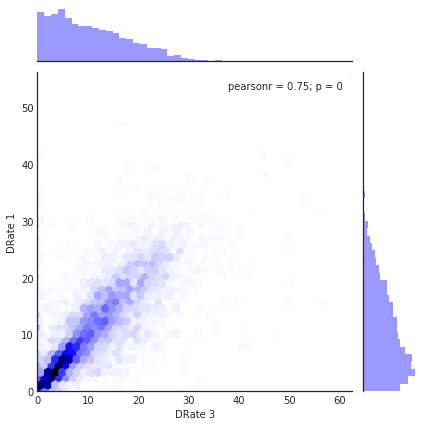

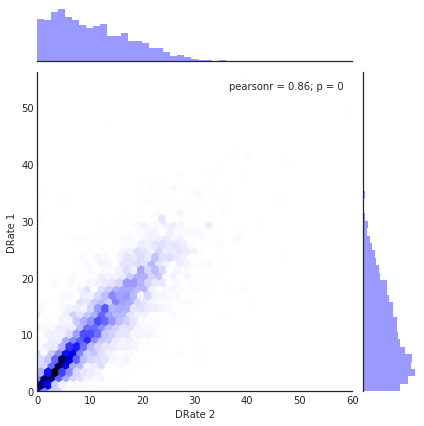

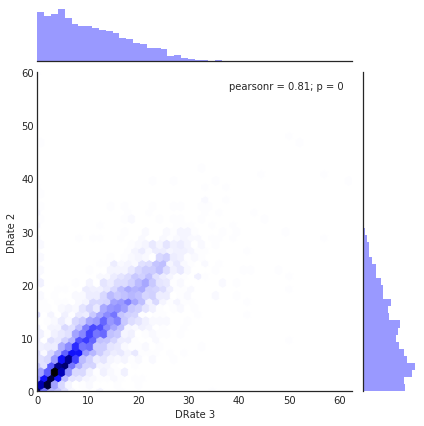

In [6]:
# Plot default rates from each fiscal year against one of them to
# see if there is much year-to-year variation
with sns.axes_style("white"):
    for y_yr, x_yr in zip([1, 1, 2], [3, 2, 3]):
        x = title5_default['DRate {}'.format(x_yr)]
        y = title5_default['DRate {}'.format(y_yr)]
        xlabel = 'Default rate in FY{}'.format(
            title5_default['Year {}'.format(x_yr)].loc[0])
        ylabel = 'Default rate in FY{}'.format(
            title5_default['Year {}'.format(y_yr)].loc[0])
        sns.jointplot(x=x, y=y, kind='hex', color='b')

In [7]:
# Calculate mean and range of values across all 3 years for each institution
title5_default['Avg. 2012-14 default rate'] = title5_default[
    ['DRate 1', 'DRate 2', 'DRate 3']].mean(axis = 1)
title5_default['Range 2012-14 default rate'] = (
    title5_default[['DRate 1', 'DRate 2', 'DRate 3']].max(axis = 1) -
    title5_default[['DRate 1', 'DRate 2', 'DRate 3']].min(axis = 1))

### Fig. 2: Scatterplots of relationships between potentially relevant variables

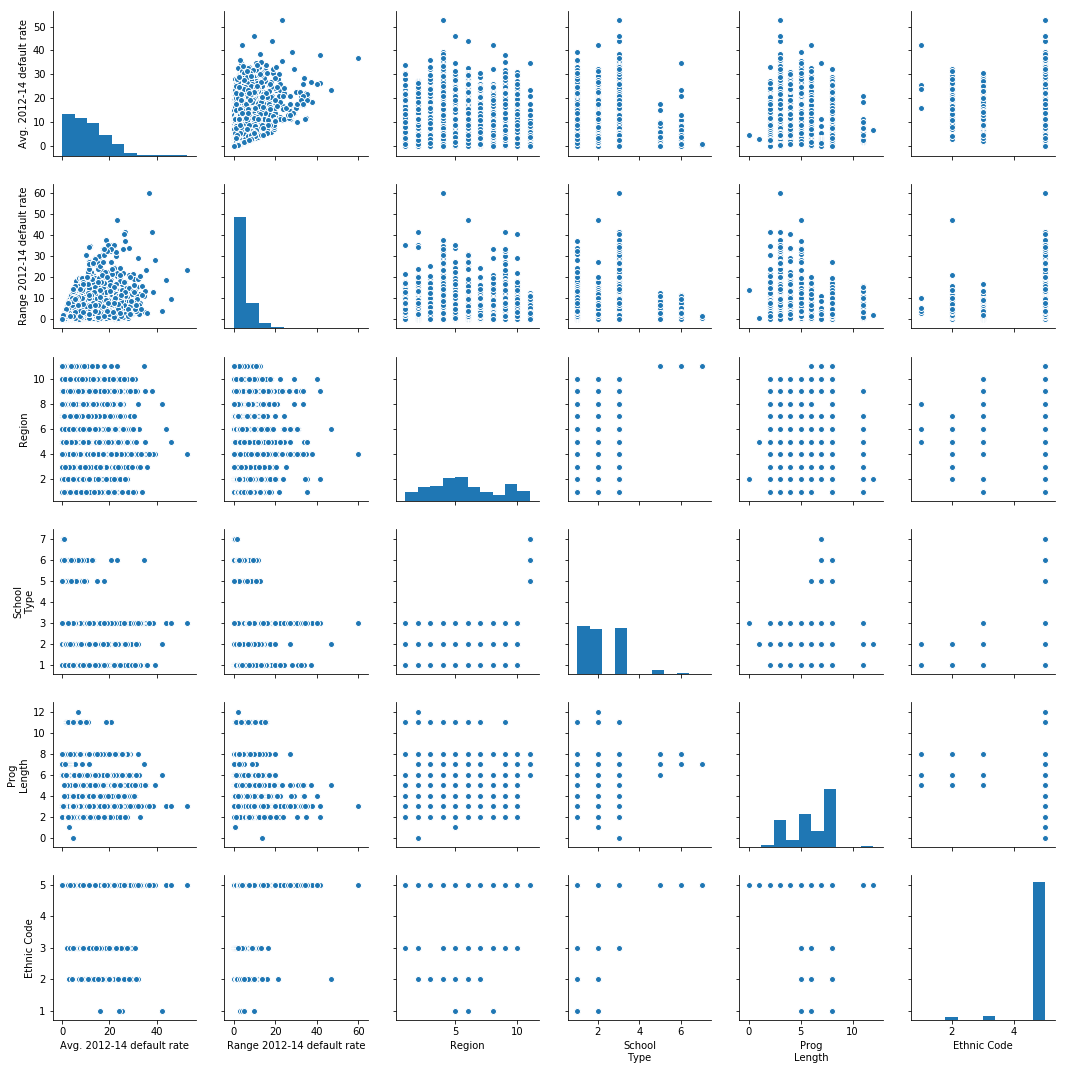

In [8]:
# subset factors that may be relevant
title5_subset = title5_default[['Avg. 2012-14 default rate',
                                'Range 2012-14 default rate',
                                'Region', 'Cong Dis', 'State',
                                'School\nType', 'Prog\nLength',
                                'Ethnic Code']].copy()
sns.pairplot(title5_subset);

In [9]:
# Calculate average default rate by state
mean_by_state = title5_default.groupby('State').mean()
# Calculate standard deviation of all default rates by state
std_by_state = title5_default.groupby('State').std()

In [10]:
# Read in shapefile with polygons of state borders
# State borders from https://www.census.gov/geo/maps-data/data/tiger-cart-boundary.html
states = gpd.read_file('cb_2016_us_state_20m/cb_2016_us_state_20m.shp')
states = states.rename(columns={'STUSPS': 'State'}).set_index('State')
# Merge statistics by state with shapefile for plotting
for code in ['DRate 1', 'DRate 2', 'DRate 3', 'Avg. 2012-14 default rate']:
    states[code + ' mean'] = mean_by_state[code]
    states[code + ' std'] = std_by_state[code]

### Fig. 3: Maps of mean default rate (left) and standard deviation of default rate (right) by state for each year and the 2012-2014 average.

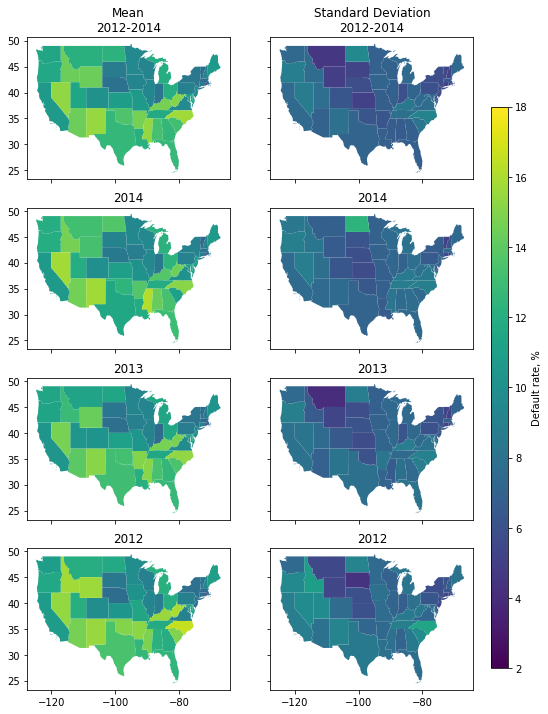

In [15]:
# Plot maps of mean and standard deviations of default rates by state.
# set up colorbar information
[vmin, vmax] = [2, 18]
fig, axarr = plt.subplots(4, 2, figsize=(8, 12), sharex=True, sharey=True)
for yr in [0, 1, 2, 3]:
    if yr == 0:
        col_id = ['Avg. 2012-14 default rate mean',
               'Avg. 2012-14 default rate std']
        title = ['Mean\n2012-2014',
                 'Standard Deviation\n2012-2014']
    else:
        col_id = ['DRate {} mean'.format(yr),
               'DRate {} std'.format(yr)]
        t = title5_default['Year {}'.format(yr)].loc[0]
        title = [t, t]
    for col in [0, 1]:
        states[(states.index != 'AK') & (states.index != 'HI') &
               (states.index != 'PR')].plot(
            ax=axarr[yr][col], column=col_id[col],
            vmin=vmin, vmax=vmax)
        axarr[yr][col].set_title(title[col])
# add colorbar
cax = fig.add_axes([0.93, 0.15, 0.03, 0.65])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax))
# fake up the array of the scalar mappable.
sm._A = []
fig.colorbar(sm, cax=cax, label='Default rate, %')